In [ ]:
import os
import pandas as pd

# Define new folder paths
base_folder = "/home/q674749/workspace/thesis_work/rat25-15.4.1"
detections_folder = os.path.join(base_folder, "detections")
objects_folder = os.path.join(base_folder, "objects")
ego_motion_folder = os.path.join(base_folder, "ego_motion")
processed_folder = os.path.join(base_folder, "processed")  # For saving new processed files
os.makedirs(processed_folder, exist_ok=True)

# Columns to retain
detections_columns = [
    "timestamp", "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity", "radialVelocityDomainMax"
]
objects_columns = [
    "timestamp", "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "status_measurement", "status_movement", "overdrivable", "underdrivable",
    "header.origin.x", "header.origin.y", "header.origin.z",
    "header.origin.roll", "header.origin.pitch", "header.origin.yaw", "reference_point"
]
ego_motion_columns = [
    "timestamp", "RotationRates.yawRateVehicleBody.value", "Velocity.SpeedCog.SpeedCog"
]

# Function to filter files
def filter_files(folder, columns_to_keep, output_subfolder):
    output_path = os.path.join(processed_folder, output_subfolder)
    os.makedirs(output_path, exist_ok=True)
    filtered_data = {}

    files = sorted([f for f in os.listdir(folder) if f.endswith(".p")])
    for file in files:
        file_path = os.path.join(folder, file)
        print(f"Processing file: {file}")
        
        # Load data
        data = pd.read_pickle(file_path)
        
        # Filter relevant columns
        filtered_df = data[columns_to_keep]
        filtered_data[file] = filtered_df
        
        # Save filtered file
        save_path = os.path.join(output_path, file)
        filtered_df.to_pickle(save_path)
        print(f"Filtered data saved to: {save_path}")

    return filtered_data

# Filter detections, objects, and ego motion files
filtered_detections = filter_files(detections_folder, detections_columns, "filtered_detections")
filtered_objects = filter_files(objects_folder, objects_columns, "filtered_objects")
filtered_ego_motion = filter_files(ego_motion_folder, ego_motion_columns, "filtered_ego_motion")

# Verify the results
print("\nFiltered files are saved in the 'processed' folder.")


: 

In [3]:
from datetime import timedelta

# Define the folder paths
filtered_detections_folder = os.path.join(processed_folder, "filtered_detections")
filtered_objects_folder = os.path.join(processed_folder, "filtered_objects")
filtered_ego_motion_folder = os.path.join(processed_folder, "filtered_ego_motion")
combined_data_folder = os.path.join(processed_folder, "combined_data")
os.makedirs(combined_data_folder, exist_ok=True)

# Function to find the closest timestamp in ego motion
def find_closest_timestamp(timestamp, ego_motion_df):
    closest_row = ego_motion_df.iloc[(ego_motion_df['timestamp'] - timestamp).abs().argsort()[:1]]
    return closest_row.iloc[0]

# Function to combine data
def combine_dataframes(detections_folder, objects_folder, ego_motion_folder, output_folder):
    combined_data = []

    # Load filtered files
    detection_files = sorted([f for f in os.listdir(detections_folder) if f.endswith(".p")])
    object_files = sorted([f for f in os.listdir(objects_folder) if f.endswith(".p")])
    ego_motion_files = sorted([f for f in os.listdir(ego_motion_folder) if f.endswith(".p")])

    # Ensure matching file pairs
    for det_file, obj_file in zip(detection_files, object_files):
        print(f"Combining {det_file} and {obj_file}...")

        # Load detections and objects
        det_path = os.path.join(detections_folder, det_file)
        obj_path = os.path.join(objects_folder, obj_file)
        detections_df = pd.read_pickle(det_path)
        objects_df = pd.read_pickle(obj_path)

        # Merge detections and objects on timestamp
        merged_df = pd.merge(detections_df, objects_df, on="timestamp", suffixes=("_det", "_obj"))

        # Find and match ego motion data
        closest_ego_motion = []
        for _, row in merged_df.iterrows():
            timestamp = row["timestamp"]
            ego_motion_data = None

            for ego_file in ego_motion_files:
                ego_path = os.path.join(ego_motion_folder, ego_file)
                ego_motion_df = pd.read_pickle(ego_path)

                try:
                    closest_row = find_closest_timestamp(timestamp, ego_motion_df)
                    ego_motion_data = {
                        "yaw_rate": closest_row["RotationRates.yawRateVehicleBody.value"],
                        "ego_speed": closest_row["Velocity.SpeedCog.SpeedCog"]
                    }
                    break
                except Exception as e:
                    print(f"No matching ego motion data for timestamp {timestamp}: {e}")

            closest_ego_motion.append(ego_motion_data)

        # Add ego motion data to the merged dataframe
        ego_motion_df = pd.DataFrame(closest_ego_motion)
        merged_df = pd.concat([merged_df, ego_motion_df.reset_index(drop=True)], axis=1)

        # Save the combined file
        save_path = os.path.join(output_folder, f"combined_{det_file}")
        merged_df.to_pickle(save_path)
        combined_data.append(merged_df)
        print(f"Combined data saved to: {save_path}")

    return combined_data

# Combine dataframes
final_combined_data = combine_dataframes(
    filtered_detections_folder,
    filtered_objects_folder,
    filtered_ego_motion_folder,
    combined_data_folder
)

# Verify combined data
print(f"\nCombined data saved in: {combined_data_folder}")


Combining frr40_detections_0.p and frr40_objects_0.p...
Combined data saved to: C:/FRR40/RAT/sample_data\processed\combined_data\combined_frr40_detections_0.p
Combining frr40_detections_1.p and frr40_objects_1.p...
Combined data saved to: C:/FRR40/RAT/sample_data\processed\combined_data\combined_frr40_detections_1.p
Combining frr40_detections_2.p and frr40_objects_2.p...
Combined data saved to: C:/FRR40/RAT/sample_data\processed\combined_data\combined_frr40_detections_2.p
Combining frr40_detections_3.p and frr40_objects_3.p...
Combined data saved to: C:/FRR40/RAT/sample_data\processed\combined_data\combined_frr40_detections_3.p

Combined data saved in: C:/FRR40/RAT/sample_data\processed\combined_data


In [7]:
import pandas as pd

# File paths
file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\combined_frr40_detections_0.p"
output_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\cleaned_data.p"

# Load the dataset
df = pd.read_pickle(file_path)

# Relevant columns to clean
relevant_columns = [
    "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity",
    "orientation", "x", "y", "width_edge_mean", "length_edge_mean",
    "transformed_x", "transformed_y", "centroids"
]

# Function to check object validity
def is_object_valid(overdrivable, underdrivable, measurement, movement):
    """
    Determine if an object is valid based on the given conditions:
    1. Sum of overdrivable + underdrivable ≤ 50
    2. Measurement is 'measured'
    3. Movement is either 0 or 'moved'
    """
    # Handle missing or invalid data
    if overdrivable is None or underdrivable is None or measurement is None or movement is None:
        return False

    # Extract data if it's a tuple
    if isinstance(measurement, tuple):
        measurement = measurement[1]
    if isinstance(movement, tuple):
        movement = movement[1]

    # Check conditions
    return (
        (overdrivable + underdrivable <= 50) and  # Condition 1
        (measurement == "measured") and          # Condition 2
        (movement in [0, "moved"])               # Condition 3
    )

# Updated cleaning function
def clean_invalid_objects(row):
    """
    Cleans invalid objects in a row based on given conditions, ensuring alignment.
    """
    # Extract validation-related columns as Python lists
    overdrivable = list(row.get("overdrivable", []))
    underdrivable = list(row.get("underdrivable", []))
    measurement = list(row.get("status_measurement", []))
    movement = list(row.get("status_movement", []))
    
    # Find the maximum number of objects in the row
    num_objects = max(len(overdrivable), len(underdrivable), len(measurement), len(movement))
    
    # Pad shorter columns with zeros or default labels
    overdrivable += [0] * (num_objects - len(overdrivable))
    underdrivable += [0] * (num_objects - len(underdrivable))
    measurement += ["unknown"] * (num_objects - len(measurement))
    movement += ["unknown"] * (num_objects - len(movement))
    
    # Create a validity mask for objects
    valid_mask = [
        is_object_valid(
            overdrivable[i], underdrivable[i], measurement[i], movement[i]
        )
        for i in range(num_objects)
    ]
    
    # Apply valid_mask to all columns
    for col in relevant_columns + ["overdrivable", "underdrivable", "status_measurement", "status_movement"]:
        if col in row:
            # Convert column to a Python list if it's not already
            row[col] = list(row[col])
            
            # Pad the column dynamically to match `valid_mask` length
            if col in ["overdrivable", "underdrivable", "rcs", "distance", "angleAzimuth", "angleElevation", "radialVelocity"]:
                row[col] += [0] * (num_objects - len(row[col]))
            else:
                row[col] += ["unknown"] * (num_objects - len(row[col]))
            
            # Safely apply `valid_mask` to filter the column
            row[col] = [
                row[col][i] for i in range(num_objects) if i < len(valid_mask) and valid_mask[i]
            ]
    
    return row

# Apply cleaning function to all rows
df_cleaned = df.apply(clean_invalid_objects, axis=1)

# Save the cleaned DataFrame
df_cleaned.to_pickle(output_path)
print(f"Cleaned data saved to: {output_path}")

# Optional: Inspect cleaned data for validation
print("Sample cleaned row:")
print(df_cleaned.iloc[0])


Cleaned data saved to: C:\FRR40\RAT\sample_data\processed\combined_data\cleaned_data.p
Sample cleaned row:
timestamp                                                    27397206.142784
rcs                                                    [12, -13, -7, 6, -13]
distance                                  [4.04, 4.12, 9.15, 9.349999, 9.59]
angleAzimuth               [-0.00518363, -0.03576181, -0.4275186, 0.51537...
angleElevation             [0.03141594, -0.039479364, -0.04089308, -0.062...
radialVelocity             [-0.114999995, -0.14, -0.145, -0.14999999, -0.12]
radialVelocityDomainMax                                            25.593336
orientation                [-1.5708438, -1.5708438, -0.56797355, -0.19175...
x                                        [27.42, 38.95, 15.4, 17.33, 137.92]
y                          [0.31, 0.45999998, -1.8499999, 1.1999999, -32.79]
width_edge_mean                         [2.01, 0.66999996, 0.29, 1.35, 0.26]
length_edge_mean            [0.17999999, 0.149

In [8]:
import numpy as np

# File paths
cleaned_file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\cleaned_data.p"
transformed_file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\transformed_data.p"

# Load the cleaned dataset
df_cleaned = pd.read_pickle(cleaned_file_path)

# Function to transform coordinates
def transform_coordinates_vcs_to_scs(row):
    """
    Transforms object coordinates from VCS to SCS for each radar cycle.
    """
    try:
        x_coords = row["x"]
        y_coords = row["y"]

        # Skip rows without valid coordinates
        if not isinstance(x_coords, list) or not isinstance(y_coords, list):
            return row

        # Convert x and y to NumPy arrays
        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

        # Sensor's position and orientation
        origin_x = row["header.origin.x"]
        origin_y = row["header.origin.y"]
        yaw = row["header.origin.yaw"]

        # Translation: Shift the VCS coordinates to the sensor's origin
        x_translated = x_coords - origin_x
        y_translated = y_coords - origin_y

        # Rotation: Apply the sensor's orientation to align with SCS
        x_scs = x_translated * np.cos(yaw) + y_translated * np.sin(yaw)
        y_scs = -x_translated * np.sin(yaw) + y_translated * np.cos(yaw)

        # Store transformed coordinates
        row["transformed_x"] = x_scs.tolist()
        row["transformed_y"] = y_scs.tolist()

    except Exception as e:
        print(f"Error in transforming row: {e}")
        row["transformed_x"] = []
        row["transformed_y"] = []

    return row

# Apply the transformation function to all rows
df_transformed = df_cleaned.apply(transform_coordinates_vcs_to_scs, axis=1)

# Save the transformed DataFrame
df_transformed.to_pickle(transformed_file_path)
print(f"Transformed data saved to: {transformed_file_path}")

# Optional: Inspect transformed data
print("Sample transformed row:")
print(df_transformed[["transformed_x", "transformed_y"]].iloc[0])


Transformed data saved to: C:\FRR40\RAT\sample_data\processed\combined_data\transformed_data.p
Sample transformed row:
transformed_x    [23.9060001373291, 35.43600082397461, 11.88599...
transformed_y    [0.6100000143051147, 0.7599999904632568, -1.54...
Name: 0, dtype: object


In [9]:
from shapely import geometry, affinity
import numpy as np

# File paths
transformed_file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\transformed_data.p"
centroid_file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\final_centroid_data.p"

# Load the transformed dataset
df_transformed = pd.read_pickle(transformed_file_path)

# Function to calculate centroids
def calculate_centroids(row):
    """
    Calculate centroids for valid objects based on transformed coordinates.
    """
    centroids = []
    try:
        for obj_x, obj_y, ref_point, length, width, orientation in zip(
            row["transformed_x"], row["transformed_y"], row["reference_point"],
            row["length_edge_mean"], row["width_edge_mean"], row["orientation"]
        ):
            # Convert orientation to degrees
            orientation_deg = orientation * 180 / np.pi

            # Create polygons based on reference points
            if ref_point == 0:
                poly = geometry.Polygon([[obj_x, obj_y], [obj_x - length, obj_y],
                                         [obj_x - length, obj_y - width], [obj_x, obj_y - width]])
            elif ref_point == 1:
                poly = geometry.Polygon([[obj_x, obj_y + width / 2], [obj_x - length, obj_y + width / 2],
                                         [obj_x - length, obj_y - width / 2], [obj_x, obj_y - width / 2]])
            elif ref_point == 2:
                poly = geometry.Polygon([[obj_x, obj_y + width], [obj_x - length, obj_y + width],
                                         [obj_x - length, obj_y], [obj_x, obj_y]])
            elif ref_point == 3:
                poly = geometry.Polygon([[obj_x + length / 2, obj_y + width], [obj_x - length / 2, obj_y + width],
                                         [obj_x - length / 2, obj_y], [obj_x + length / 2, obj_y]])
            else:
                # Default square for unknown reference points
                poly = geometry.Polygon([[obj_x + 1, obj_y + 1], [obj_x - 1, obj_y + 1],
                                         [obj_x - 1, obj_y - 1], [obj_x + 1, obj_y - 1]])

            # Rotate the polygon around the object's coordinates
            poly = affinity.rotate(poly, orientation_deg, origin=(obj_x, obj_y))

            # Calculate centroid
            centroids.append((poly.centroid.x, poly.centroid.y))
    except Exception as e:
        print(f"Error calculating centroids: {e}")
        centroids.append(None)

    # Add centroids to the row
    row["centroids"] = centroids
    return row

# Apply the centroid calculation function
df_centroid = df_transformed.apply(calculate_centroids, axis=1)

# Save the dataset with centroids
df_centroid.to_pickle(centroid_file_path)
print(f"Final data with centroids saved to: {centroid_file_path}")

# Optional: Inspect the final data
print("Sample data with centroids:")
print(df_centroid[["transformed_x", "transformed_y", "centroids"]].iloc[0])


Final data with centroids saved to: C:\FRR40\RAT\sample_data\processed\combined_data\final_centroid_data.p
Sample data with centroids:
transformed_x    [23.9060001373291, 35.43600082397461, 11.88599...
transformed_y    [0.6100000143051147, 0.7599999904632568, -1.54...
centroids        [(23.9060001373291, 0.6100000143051132), (35.4...
Name: 0, dtype: object


In [11]:
import pandas as pd

# File paths
centroid_file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\final_centroid_data.p"

# Load the final processed data
df_final = pd.read_pickle(centroid_file_path)

# Verify a few rows of the final data
print("Final Data Sample with Centroids:")
print(df_final[["timestamp", "transformed_x", "transformed_y", "centroids"]].head())

# Validate centroids for a random object
def validate_centroid(row_index, df):
    row = df.iloc[row_index]
    print(f"\nValidating Row {row_index}:")
    print("Transformed Coordinates (x, y):")
    print(f"x: {row['transformed_x']}")
    print(f"y: {row['transformed_y']}")
    print("Centroids:")
    print(row["centroids"])

# Validate centroids for a few rows
validate_centroid(0, df_final)  # Validate the first row
validate_centroid(1, df_final)  # Validate the second row
validate_centroid(2, df_final)  # Validate the third row


Final Data Sample with Centroids:
      timestamp                                      transformed_x  \
0  2.739721e+07  [23.9060001373291, 35.43600082397461, 11.88599...   
1  2.739721e+07  [35.66600036621094, 11.97599983215332, 14.8959...   
2  2.739721e+07  [12.125999450683594, 16.17599868774414, 137.25...   
3  2.739721e+07  [36.795997619628906, 12.305999755859375, 17.22...   
4  2.739721e+07  [36.24599838256836, 12.586000442504883, 18.475...   

                                       transformed_y  \
0  [0.6100000143051147, 0.7599999904632568, -1.54...   
1  [0.5099999904632568, -1.5999999046325684, 1.35...   
2  [-1.6599998474121094, 1.159999966621399, -33.7...   
3  [11.0600004196167, -1.6299998760223389, 1.0199...   
4  [11.899999618530273, -1.5999999046325684, 0.85...   

                                           centroids  
0  [(23.9060001373291, 0.6100000143051132), (35.4...  
1  [(35.666000366210945, 0.5099999904632604), (11...  
2  [(12.125999450683592, -1.65999984741211)

In [13]:
import pandas as pd

# File path of the final processed dataset
centroid_file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\final_centroid_data.p"

# Load the final processed data
df_final = pd.read_pickle(centroid_file_path)

# Print the list of all columns
print("Columns in the final dataset:")
print(df_final.columns.tolist())


Columns in the final dataset:
['timestamp', 'rcs', 'distance', 'angleAzimuth', 'angleElevation', 'radialVelocity', 'radialVelocityDomainMax', 'orientation', 'x', 'y', 'width_edge_mean', 'length_edge_mean', 'status_measurement', 'status_movement', 'overdrivable', 'underdrivable', 'header.origin.x', 'header.origin.y', 'header.origin.z', 'header.origin.roll', 'header.origin.pitch', 'header.origin.yaw', 'reference_point', 'yaw_rate', 'ego_speed', 'transformed_x', 'transformed_y', 'centroids']



--- Validating Transformed Coordinates ---


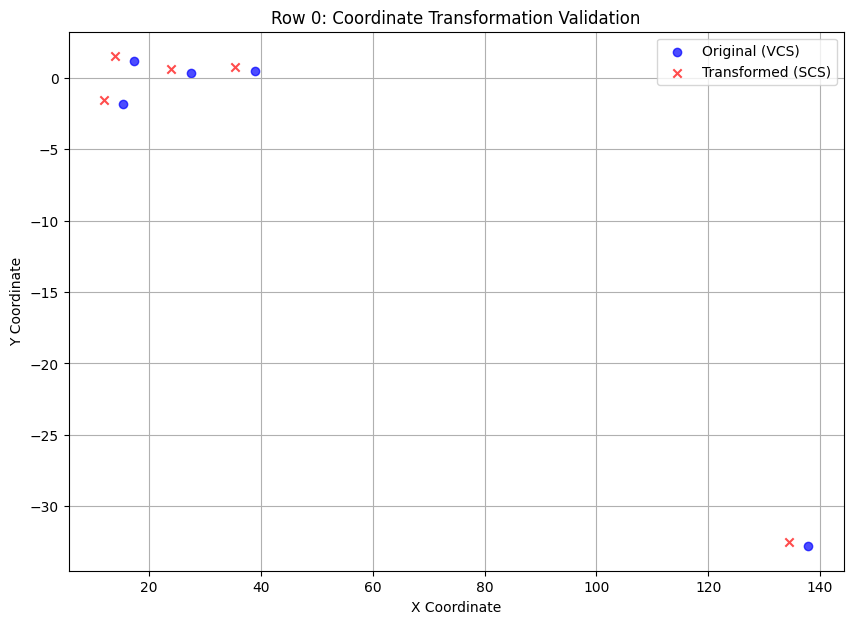

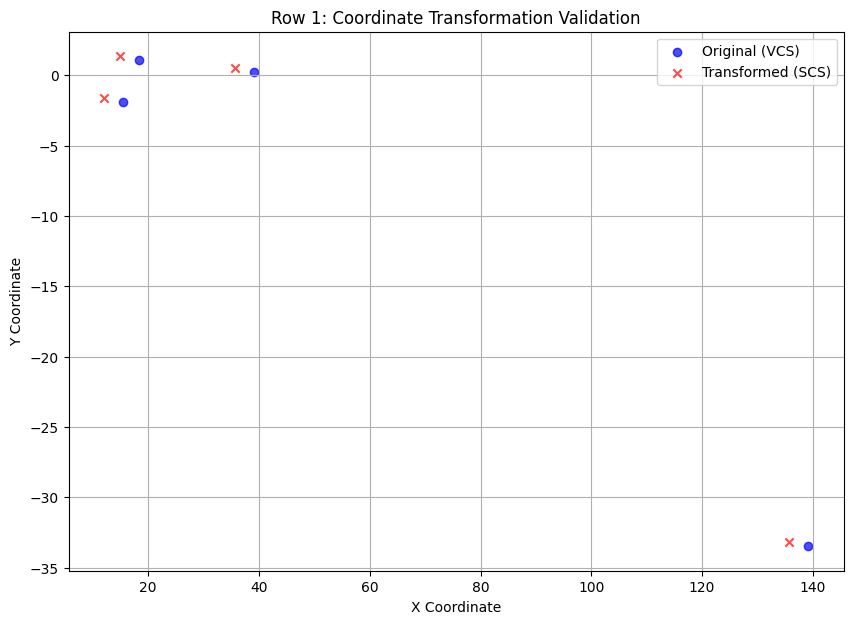

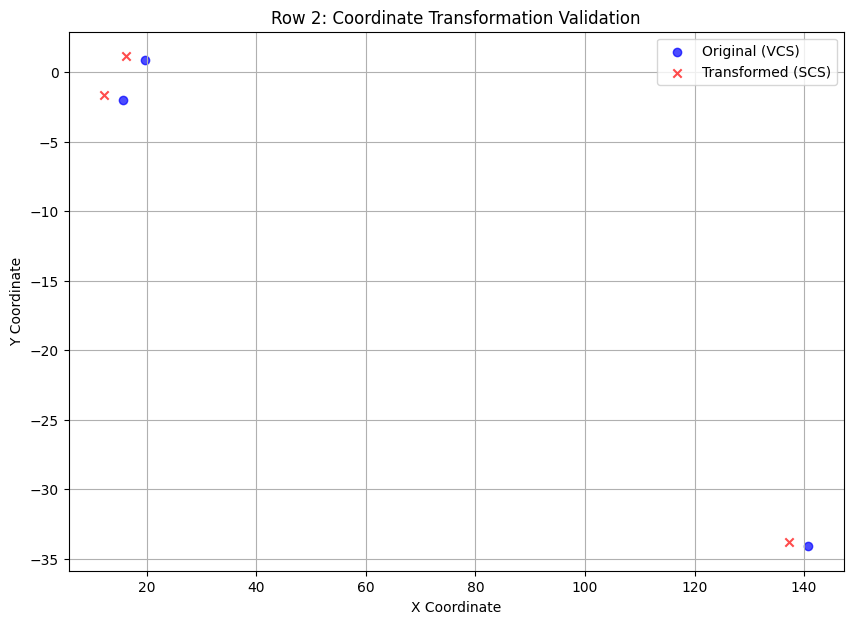

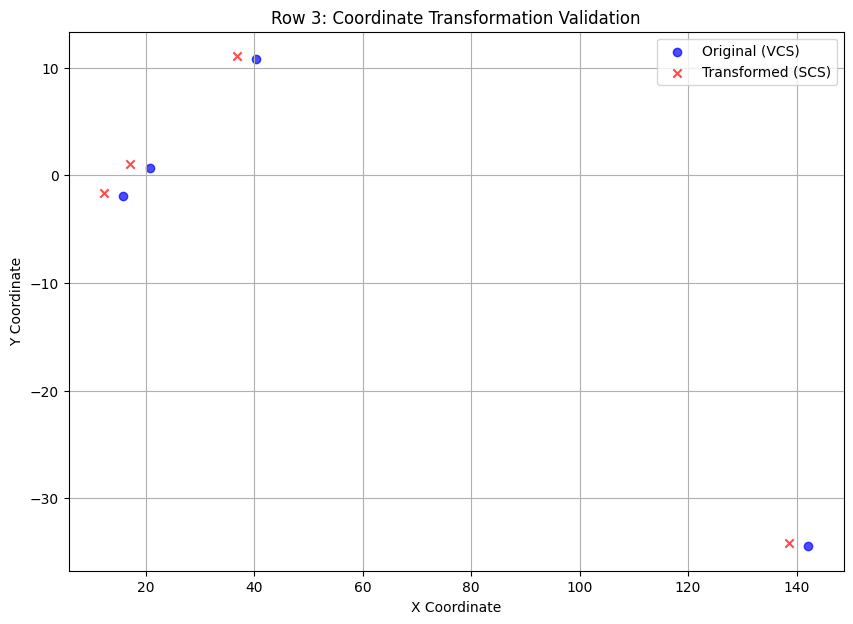

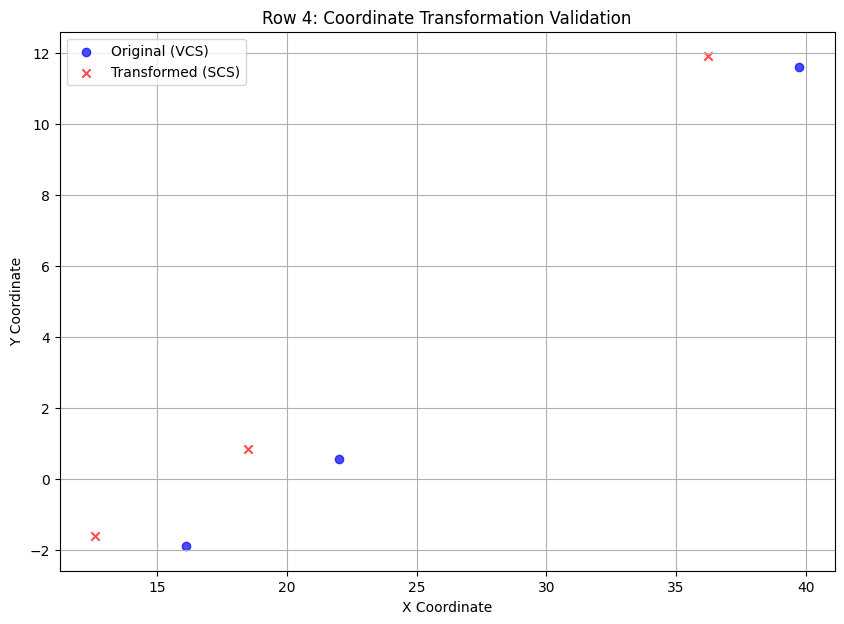

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_transformation_with_conversion(file_path, rows_to_plot=5):
    """
    Plots the original (VCS) and transformed (SCS) coordinates to validate the transformation.
    """
    # Load the dataset
    df = pd.read_pickle(file_path)

    print(f"\n--- Validating Transformed Coordinates ---")

    # Iterate over the specified number of rows
    for idx, row in df.head(rows_to_plot).iterrows():
        try:
            # Extract coordinates
            original_x = row.get("x", [])
            original_y = row.get("y", [])
            transformed_x = row.get("transformed_x", [])
            transformed_y = row.get("transformed_y", [])

            # Ensure coordinates are in list format
            if not isinstance(original_x, list):
                original_x = list(original_x)
            if not isinstance(original_y, list):
                original_y = list(original_y)
            if not isinstance(transformed_x, list):
                transformed_x = list(transformed_x)
            if not isinstance(transformed_y, list):
                transformed_y = list(transformed_y)

            # Validate that both original and transformed coordinates are available
            if not original_x or not original_y:
                print(f"Row {idx} skipped: Missing original coordinates.")
                continue
            if not transformed_x or not transformed_y:
                print(f"Row {idx} skipped: Missing transformed coordinates.")
                continue

            # Plot the coordinates
            plt.figure(figsize=(10, 7))
            plt.scatter(original_x, original_y, label="Original (VCS)", marker="o", alpha=0.7, color="blue")
            plt.scatter(transformed_x, transformed_y, label="Transformed (SCS)", marker="x", alpha=0.7, color="red")
            plt.title(f"Row {idx}: Coordinate Transformation Validation")
            plt.xlabel("X Coordinate")
            plt.ylabel("Y Coordinate")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"Error plotting row {idx}: {e}")

# File path to validate
file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\final_centroid_data.p"

# Run the plot function to validate
plot_transformation_with_conversion(file_path, rows_to_plot=5)


In [20]:
import pandas as pd
import numpy as np
from shapely import geometry, affinity

def validate_polygon_calculation_step_by_step(x, y, ref_point, length, width, orientation):
    """
    Validates polygon and centroid calculation step-by-step for a single object.
    Shows formulas, substituted values, intermediate steps, and the effect of orientation.
    """
    try:
        orientation_deg = orientation * 180 / np.pi  # Convert radians to degrees
        print(f"\nInput Data:")
        print(f"  x: {x}, y: {y}, ref_point: {ref_point}, length: {length}, width: {width}, orientation: {orientation_deg:.2f}°")

        # Determine polygon points based on reference point
        if ref_point == 0:  # Top-left corner
            poly_points = [
                [x, y], [x - length, y], [x - length, y - width], [x, y - width]
            ]
            formula = "1. Top-left corner: Points: [(x, y), (x - length, y), (x - length, y - width), (x, y - width)]"
        elif ref_point == 1:  # Middle-left edge
            poly_points = [
                [x, y + width / 2], [x - length, y + width / 2],
                [x - length, y - width / 2], [x, y - width / 2]
            ]
            formula = "2. Middle-left edge: Points: [(x, y + width/2), (x - length, y + width/2), (x - length, y - width/2), (x, y - width/2)]"
        elif ref_point == 2:  # Bottom-left corner
            poly_points = [
                [x, y + width], [x - length, y + width], [x - length, y], [x, y]
            ]
            formula = "3. Bottom-left corner: Points: [(x, y + width), (x - length, y + width), (x - length, y), (x, y)]"
        elif ref_point == 3:  # Center-top edge
            poly_points = [
                [x + length / 2, y + width], [x - length / 2, y + width],
                [x - length / 2, y], [x + length / 2, y]
            ]
            formula = "4. Center-top edge: Points: [(x + length/2, y + width), (x - length/2, y + width), (x - length/2, y), (x + length/2, y)]"
        else:  # Default square
            poly_points = [
                [x + 1, y + 1], [x - 1, y + 1], [x - 1, y - 1], [x + 1, y - 1]
            ]
            formula = "5. Default square: Points: [(x + 1, y + 1), (x - 1, y + 1), (x - 1, y - 1), (x + 1, y - 1)]"

        print(f"\nPolygon Formula: {formula}")
        print(f"  Substituted Points: {poly_points}")

        # Rotate the polygon based on orientation
        poly = geometry.Polygon(poly_points)
        rotated_poly = affinity.rotate(poly, orientation_deg, origin=(x, y))
        rotated_points = list(rotated_poly.exterior.coords)[:-1]  # Exclude last repeated point
        print(f"\nEffect of Orientation (Rotation by {orientation_deg:.2f}°):")
        print(f"  Rotated Polygon Points: {rotated_points}")

        # Centroid formula explanation
        print("\nCentroid Calculation:")
        print("  Centroid X = Average of X-coordinates of vertices")
        print("  Centroid Y = Average of Y-coordinates of vertices")
        centroid_x = sum(v[0] for v in rotated_points) / len(rotated_points)
        centroid_y = sum(v[1] for v in rotated_points) / len(rotated_points)
        print(f"  Substituted X-coordinates: {[v[0] for v in rotated_points]}")
        print(f"  Substituted Y-coordinates: {[v[1] for v in rotated_points]}")
        print(f"  Centroid X = {centroid_x:.2f}, Centroid Y = {centroid_y:.2f}")

        # Return the computed centroid
        return (centroid_x, centroid_y)
    except Exception as e:
        print(f"Error processing object: {e}")
        return None


# Load dataset for validation
file_path = r"C:\FRR40\RAT\sample_data\processed\combined_data\final_centroid_data.p"
df = pd.read_pickle(file_path)

# Validate centroids for a few objects in specific rows
sample_indices = [0, 1, 2, 3, 4]  # Adjust based on rows you'd like to validate

for idx in sample_indices:
    row = df.iloc[idx]
    print(f"\n--- Validation for Row {idx} ---")
    for obj_idx in range(len(row["transformed_x"])):
        print(f"Object {obj_idx}:")
        validate_polygon_calculation_step_by_step(
            row["transformed_x"][obj_idx],
            row["transformed_y"][obj_idx],
            row["reference_point"][obj_idx],
            row["length_edge_mean"][obj_idx],
            row["width_edge_mean"][obj_idx],
            row["orientation"][obj_idx]
        )
        print("=" * 80)



--- Validation for Row 0 ---
Object 0:

Input Data:
  x: 23.9060001373291, y: 0.6100000143051147, ref_point: (1, 'Middle_Front'), length: 0.17999999225139618, width: 2.009999990463257, orientation: -90.00°

Polygon Formula: 5. Default square: Points: [(x + 1, y + 1), (x - 1, y + 1), (x - 1, y - 1), (x + 1, y - 1)]
  Substituted Points: [[24.9060001373291, 1.6100000143051147], [22.9060001373291, 1.6100000143051147], [22.9060001373291, -0.38999998569488525], [24.9060001373291, -0.38999998569488525]]

Effect of Orientation (Rotation by -90.00°):
  Rotated Polygon Points: [(24.905952647192883, -0.39004747357589764), (24.90604762521011, 1.6099525241688966), (22.906047627465316, 1.6100475021861236), (22.905952649448093, -0.3899524955586706)]

Centroid Calculation:
  Centroid X = Average of X-coordinates of vertices
  Centroid Y = Average of Y-coordinates of vertices
  Substituted X-coordinates: [24.905952647192883, 24.90604762521011, 22.906047627465316, 22.905952649448093]
  Substituted Y-c